In [95]:
import numpy as np
import math

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram

sampler = Sampler()

First we define some support function


In [96]:
def convert_binary(decimal_number):
    binary_number = bin(decimal_number)[2:]  # Remove the "0b" prefix
    binary_digit_list = [int(digit) for digit in binary_number]

    return binary_digit_list

def add_padding(list1, max_length):
    
    if len(list1) <= max_length:
        list1 = [0] * (max_length - len(list1)) + list1
    
    if len(list1) > max_length:
        exit('Error: number to big')

    return list1

def initialize(bin_num):
    n = len(bin_num)
    circ = QuantumCircuit(n, name="init %s" % str(bin_num))
    for jj in range(n):
        if bin_num[jj] == 1:
            circ.x(jj)
    
    return circ.to_gate()


def test(circ):
    circ.measure_all()
    job_t = sampler.run(circ)
    res_t = job_t.result()
    print(res_t.quasi_dists[0].binary_probabilities())


Here we define the QFT, in according to the way in which it is implemented in the project description

In [97]:
def qft(n):
    q = QuantumRegister(n, name='q')
    circ = QuantumCircuit(q, name='QFT')
    # QFT with n qubits
    # First we apply hadamard and control phase gates
    for j in range(n):
        circ.h(q[j])
        num = 2
        for k in range(j+1,n):
            circ.cp(2*math.pi / 2 ** num, q[k], q[j])
            num += 1
        circ.barrier()
    # Now finish the QFT by reversing the order of the qubits
    # for j in range(n//2):
    #     circ.swap(q[j], q[n - j - 1])
        
    return circ


$$ Sum|m\rangle |k\rangle = |m\rangle|m+k\rangle.$$

First we prepare the state

In [98]:
a, b = 5, 8
bin_a, bin_b  = convert_binary(a), convert_binary(b)
print('a:',bin_a,' b: ',bin_b)

in_dim = max(len(bin_a),len(bin_b))

bin_a, bin_b = add_padding(bin_a, in_dim+1), add_padding(bin_b, in_dim)
print('a: ',bin_a, ' b: ',bin_b)

b_qubits = QuantumRegister(in_dim, name='b') 
a_qubits = QuantumRegister(in_dim+1, name='a')
c = ClassicalRegister(in_dim+1, name='c')

qc = QuantumCircuit(b_qubits, a_qubits, c)

qc.append(initialize(bin_b), b_qubits)
qc.append(initialize(bin_a), a_qubits)
qc.barrier()

qc.decompose().draw()


a: [1, 0, 1]  b:  [1, 0, 0, 0]
a:  [0, 0, 1, 0, 1]  b:  [1, 0, 0, 0]


┌───┐ ░ 
b_0: ┤ X ├─░─
     └───┘ ░ 
b_1: ──────░─
           ░ 
b_2: ──────░─
           ░ 
b_3: ──────░─
           ░ 
a_0: ──────░─
           ░ 
a_1: ──────░─
     ┌───┐ ░ 
a_2: ┤ X ├─░─
     └───┘ ░ 
a_3: ──────░─
     ┌───┐ ░ 
a_4: ┤ X ├─░─
     └───┘ ░ 
c: 5/════════

Secondly, we add the QFT

In [99]:
qc.append(qft(in_dim+1), a_qubits)
qc.barrier()
# test(qc)
qc.decompose().draw()


┌───┐ ░                                                            »
b_0: ┤ X ├─░────────────────────────────────────────────────────────────»
     └───┘ ░                                                            »
b_1: ──────░────────────────────────────────────────────────────────────»
           ░                                                            »
b_2: ──────░────────────────────────────────────────────────────────────»
           ░                                                            »
b_3: ──────░────────────────────────────────────────────────────────────»
           ░ ┌───┐                                      ░               »
a_0: ──────░─┤ H ├─■────────■────────■────────■─────────░───────────────»
           ░ └───┘ │P(π/2)  │        │        │         ░ ┌───┐         »
a_1: ──────░───────■────────┼────────┼────────┼─────────░─┤ H ├─■───────»
     ┌───┐ ░                │P(π/4)  │        │         ░ └───┘ │P(π/2) »
a_2: ┤ X ├─░────────────────■────────┼────────┼─────────░───────■───────»
     └───┘ ░                         │P(π/8)  │         ░               »
a_3: ──────░─────────────────────────■────────┼─────────░───────────────»
     ┌───┐ ░                                  │P(π/16)  ░               »
a_4: ┤ X ├─░──────────────────────────────────■─────────░───────────────»
     └───┘ ░                                            ░               »
c: 5/═══════════════════════════════════════════════════════════════════»
                                                                        »
«                                                                             »
«b_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«b_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«b_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«b_3: ────────────────────────────────────────────────────────────────────────»
«                        ░                         ░                ░       ░ »
«a_0: ───────────────────░─────────────────────────░────────────────░───────░─»
«                        ░                         ░                ░       ░ »
«a_1: ─■────────■────────░─────────────────────────░────────────────░───────░─»
«      │        │        ░ ┌───┐                   ░                ░       ░ »
«a_2: ─┼────────┼────────░─┤ H ├─■────────■────────░────────────────░───────░─»
«      │P(π/4)  │        ░ └───┘ │P(π/2)  │        ░ ┌───┐          ░       ░ »
«a_3: ─■────────┼────────░───────■────────┼────────░─┤ H ├─■────────░───────░─»
«               │P(π/8)  ░                │P(π/4)  ░ └───┘ │P(π/2)  ░ ┌───┐ ░ »
«a_4: ──────────■────────░────────────────■────────░───────■────────░─┤ H ├─░─»
«                        ░                         ░                ░ └───┘ ░ »
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«      ░ 
«b_0: ─░─
«      ░ 
«b_1: ─░─
«      ░ 
«b_2: ─░─
«      ░ 
«b_3: ─░─
«      ░ 
«a_0: ─░─
«      ░ 
«a_1: ─░─
«      ░ 
«a_2: ─░─
«      ░ 
«a_3: ─░─
«      ░ 
«a_4: ─░─
«      ░ 
«c: 5/═══
«

Now we can perform the sum

In [100]:

num = 2
for j in range(0, in_dim):
    qc.cp(2*math.pi / 2 ** num, b_qubits[j], a_qubits[0])
    num += 1
qc.barrier()

for i in range(1, in_dim+1):
    num = 1
    for j in range(i-1, in_dim):
        qc.cp(2*math.pi / 2 ** num, b_qubits[j], a_qubits[i])
        num += 1
    qc.barrier()

qc.draw()

┌────────────────────┐  ░          ░                            »
b_0: ──┤0                   ├──░──────────░──■─────────────────────────»
       │                    │  ░          ░  │                         »
b_1: ──┤1                   ├──░──────────░──┼────────■────────────────»
       │  init [1, 0, 0, 0] │  ░          ░  │        │                »
b_2: ──┤2                   ├──░──────────░──┼────────┼────────■───────»
       │                    │  ░          ░  │        │        │       »
b_3: ──┤3                   ├──░──────────░──┼────────┼────────┼───────»
     ┌─┴────────────────────┴┐ ░ ┌──────┐ ░  │P(π/2)  │P(π/4)  │P(π/8) »
a_0: ┤0                      ├─░─┤0     ├─░──■────────■────────■───────»
     │                       │ ░ │      │ ░                            »
a_1: ┤1                      ├─░─┤1     ├─░────────────────────────────»
     │                       │ ░ │      │ ░                            »
a_2: ┤2 init [0, 0, 1, 0, 1] ├─░─┤2 QFT ├─░────────────────────────────»
     │                       │ ░ │      │ ░                            »
a_3: ┤3                      ├─░─┤3     ├─░────────────────────────────»
     │                       │ ░ │      │ ░                            »
a_4: ┤4                      ├─░─┤4     ├─░────────────────────────────»
     └───────────────────────┘ ░ └──────┘ ░                            »
c: 5/══════════════════════════════════════════════════════════════════»
                                                                       »
«                ░                                    ░                 »
«b_0: ───────────░──■─────────────────────────────────░─────────────────»
«                ░  │                                 ░                 »
«b_1: ───────────░──┼──────■──────────────────────────░──■──────────────»
«                ░  │      │                          ░  │              »
«b_2: ───────────░──┼──────┼────────■─────────────────░──┼──────■───────»
«                ░  │      │        │                 ░  │      │       »
«b_3: ─■─────────░──┼──────┼────────┼────────■────────░──┼──────┼───────»
«      │P(π/16)  ░  │      │        │        │        ░  │      │       »
«a_0: ─■─────────░──┼──────┼────────┼────────┼────────░──┼──────┼───────»
«                ░  │P(π)  │P(π/2)  │P(π/4)  │P(π/8)  ░  │      │       »
«a_1: ───────────░──■──────■────────■────────■────────░──┼──────┼───────»
«                ░                                    ░  │P(π)  │P(π/2) »
«a_2: ───────────░────────────────────────────────────░──■──────■───────»
«                ░                                    ░                 »
«a_3: ───────────░────────────────────────────────────░─────────────────»
«                ░                                    ░                 »
«a_4: ───────────░────────────────────────────────────░─────────────────»
«                ░                                    ░                 »
«c: 5/══════════════════════════════════════════════════════════════════»
«                                                                       »
«               ░                  ░         ░ 
«b_0: ──────────░──────────────────░─────────░─
«               ░                  ░         ░ 
«b_1: ──────────░──────────────────░─────────░─
«               ░                  ░         ░ 
«b_2: ──────────░──■───────────────░─────────░─
«               ░  │               ░         ░ 
«b_3: ─■────────░──┼──────■────────░──■──────░─
«      │        ░  │      │        ░  │      ░ 
«a_0: ─┼────────░──┼──────┼────────░──┼──────░─
«      │        ░  │      │        ░  │      ░ 
«a_1: ─┼────────░──┼──────┼────────░──┼──────░─
«      │P(π/4)  ░  │      │        ░  │      ░ 
«a_2: ─■────────░──┼──────┼────────░──┼──────░─
«               ░  │P(π)  │P(π/2)  ░  │      ░ 
«a_3: ──────────░──■──────■────────░──┼──────░─
«               ░                  ░  │P(π)  ░ 
«a_4: ──────────░──────────────────░──■──────░─
«               ░                  ░         ░ 
«c: 5/══

Finally, we add the QFT inverse and measurement

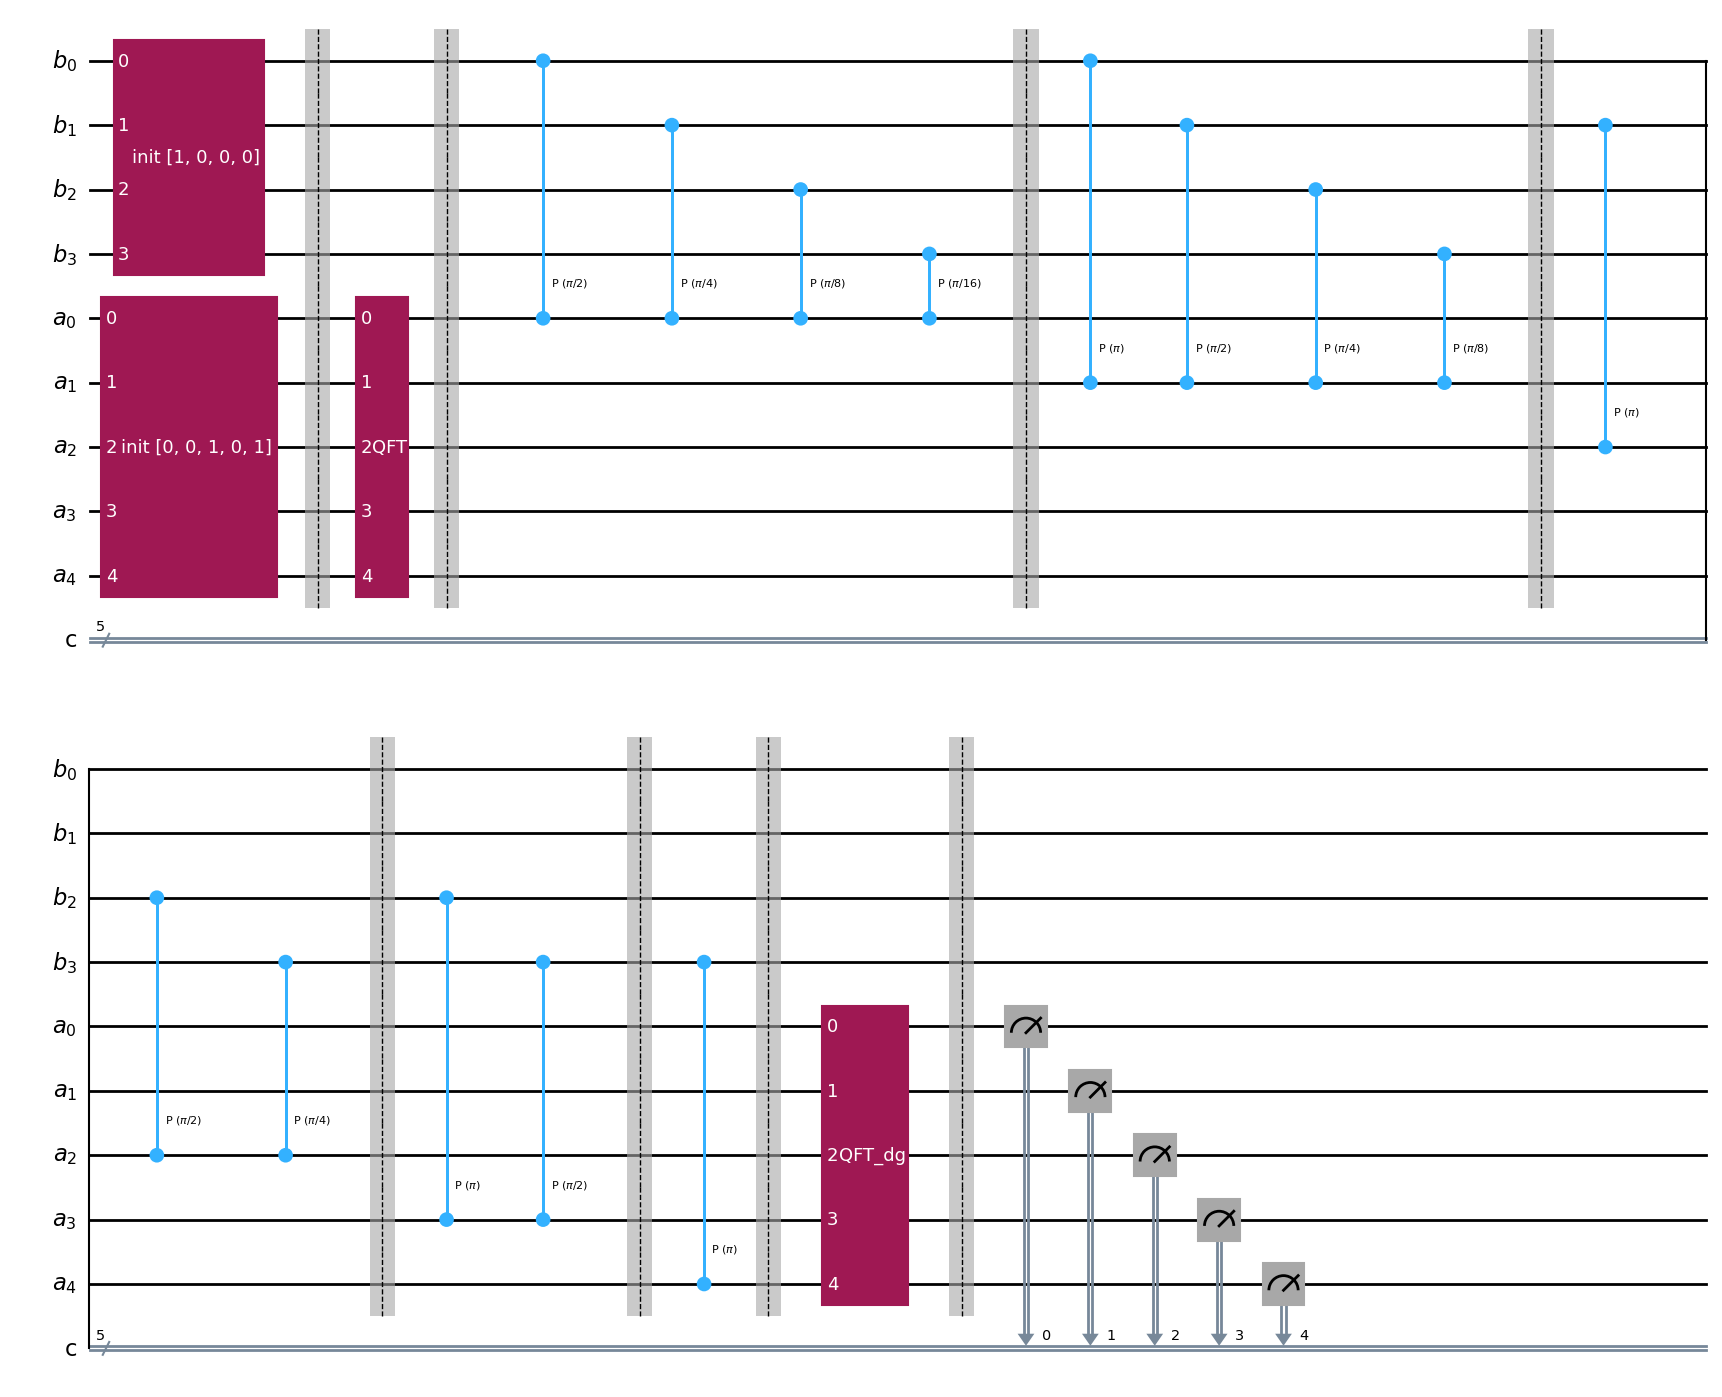

In [101]:
qc.append(qft(in_dim+1).inverse(), a_qubits)
qc.barrier()

   
qc.measure(a_qubits, c)
qc.draw('mpl')


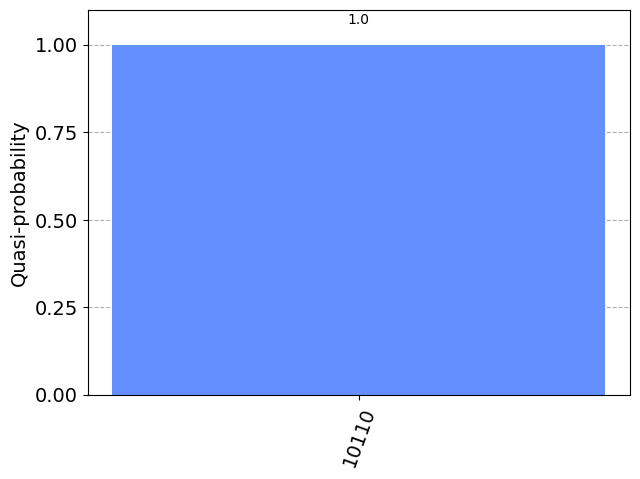

In [102]:

job = sampler.run(qc)
res = job.result()
out = res.quasi_dists[0].binary_probabilities()
plot_histogram(out)

In [107]:
def reverse(s):
    rev = ""
    for ch in s:
        rev = ch + rev
    return rev


for state in out:
    string = reverse(state)
    print('%i + %i:\n\tin binary: %s, decimal: %i' % (a,b,string,int(string,2)))

5 + 8:
	in binary: 01101, decimal: 13
